In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from numpy import mean
from numpy import std
%matplotlib inline

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
#Importing the dataset and assigning it to a variable
df= pd.read_csv("/content/drive/MyDrive/fraud_detection_dataset.csv")

In [79]:
temp= df #keeping all the variable in a temporary dataframe
temp.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#**Data Preprocessing and Cleaning**

In [80]:
rows, cols = df.shape
print(f' There are {rows} rows and {cols} columns in the dataset.')

 There are 6362620 rows and 11 columns in the dataset.


In [81]:
df.head()#Printing the first 5 rows in the dataset

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [82]:
df.info() #information relating to the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [83]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

#**NOTE: There are no null values in the dataset. Cleaning isn't necessary.**

In [84]:
print(f'There are {df.duplicated().sum()} No. of duplicates in the dataset.')

There are 0 No. of duplicates in the dataset.


# **Note: It appears there are no duplicates in the dataset. Dropping isnt necessary**

In [85]:
#Checking whether the class (Dependent feature = "isFraud") is imbalanced or not
df['isFraud'].value_counts(normalize = True) * 100

0    99.870918
1     0.129082
Name: isFraud, dtype: float64

# **Note: It appears that the dataset is imbalanced as the feature contains 99.8% of fields including value '1' and 0.12% including '0'. To resolve this problem so as to equally partition the train and test, we will split this data using the stratified sampling method in train_test_split phase**

In [86]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [87]:
df["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [88]:
df.describe() #Summary of the data

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


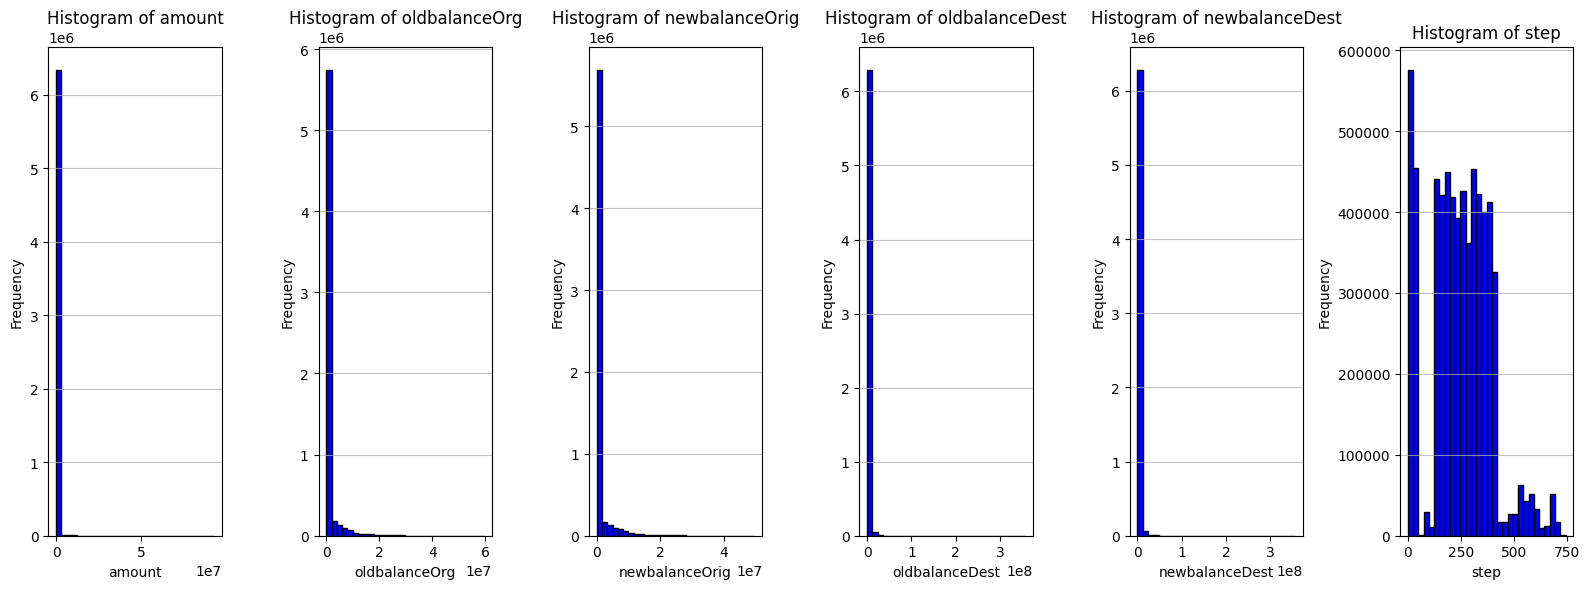

In [89]:
numeric_columns = ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest", "step"]
# Plot histograms for each numeric column
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(16, 6))

for i, column in enumerate(numeric_columns[:6]):
    axes[i].hist(df[column], bins=30, color='blue', edgecolor='black')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(axis='y', alpha=0.75)

# Adjust layout for better readability
plt.tight_layout()
plt.show()

The histograms of the dataset reveal left-skewed data distributions

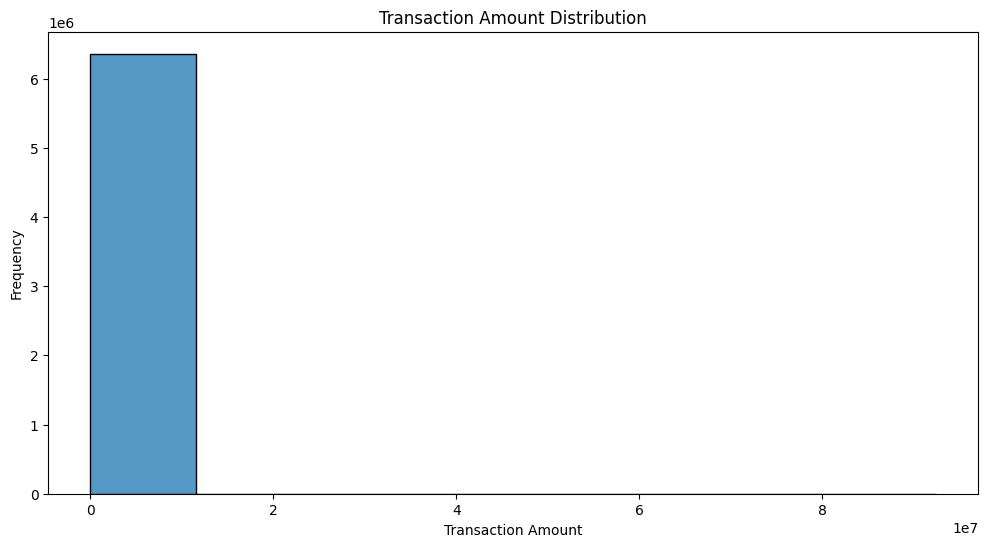

In [19]:
# Data Distribution Visualization for txn amt
plt.figure(figsize=(12, 6))
sns.histplot(df['amount'], bins=8)
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.show()

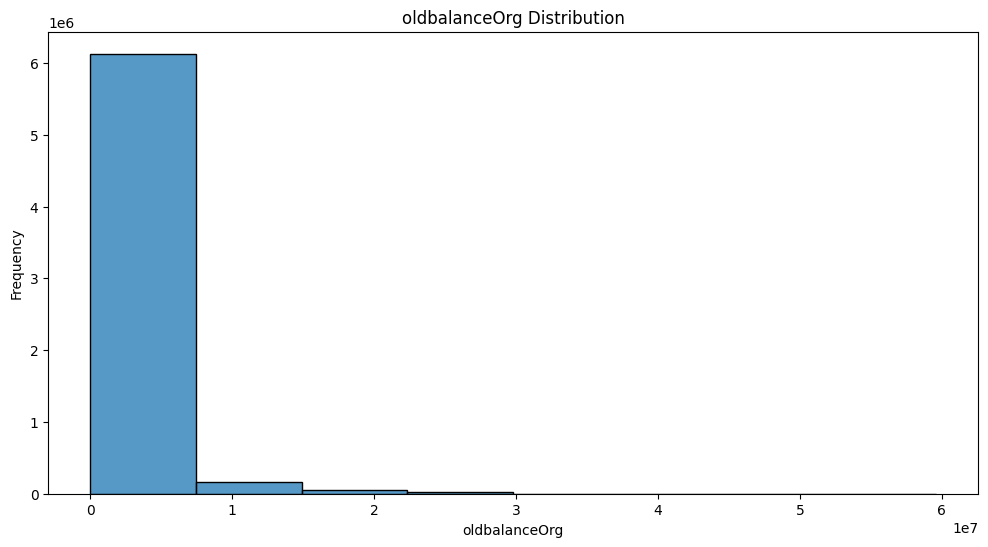

In [20]:
# Data Distribution Visualization for old balance orig
plt.figure(figsize=(12, 6))
sns.histplot(df['oldbalanceOrg'], bins=8)
plt.title('oldbalanceOrg Distribution')
plt.xlabel('oldbalanceOrg')
plt.ylabel('Frequency')
plt.show()

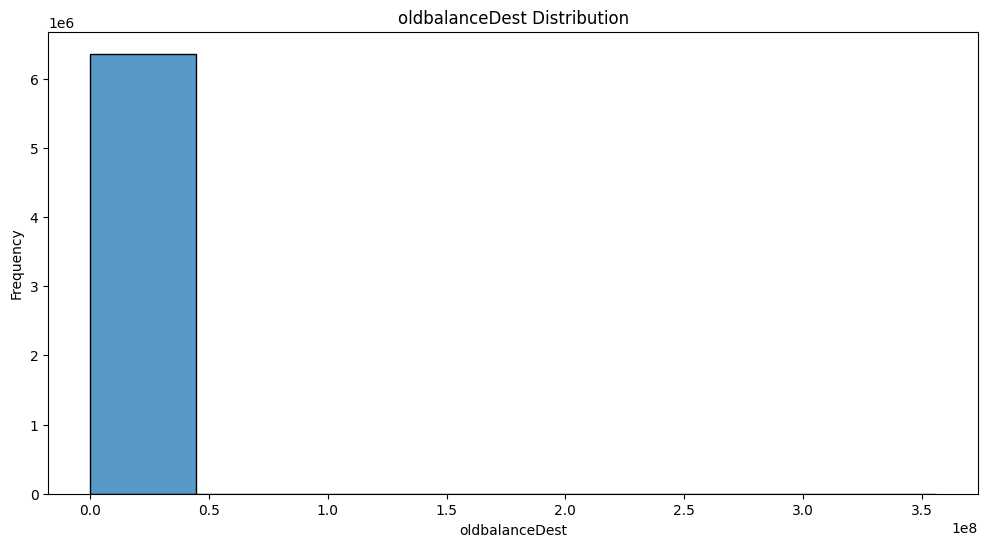

In [21]:
# Data Distribution Visualization for old balance Dest
plt.figure(figsize=(12, 6))
sns.histplot(df['oldbalanceDest'], bins=8)
plt.title('oldbalanceDest Distribution')
plt.xlabel('oldbalanceDest')
plt.ylabel('Frequency')
plt.show()

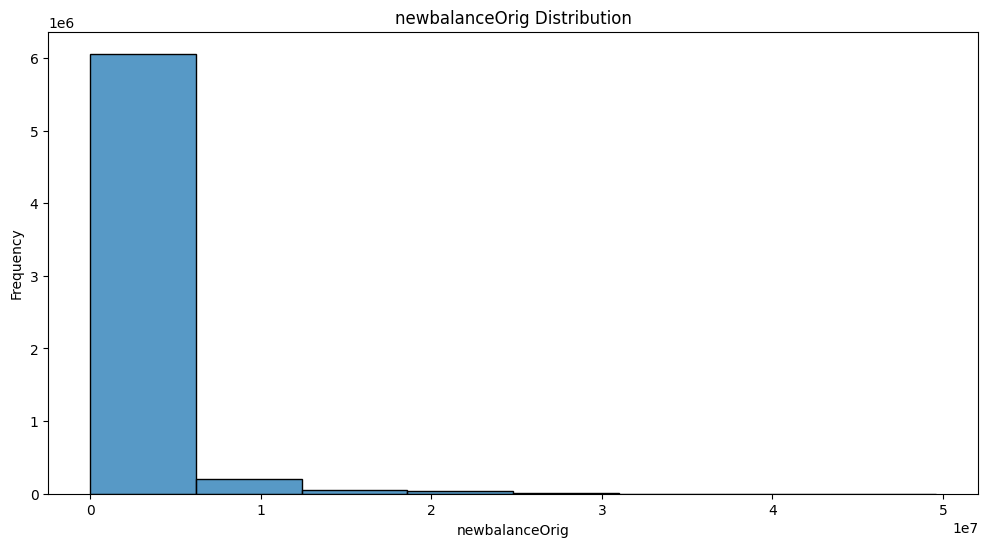

In [22]:
# Data Distribution Visualization for new balance orig
plt.figure(figsize=(12, 6))
sns.histplot(df['newbalanceOrig'], bins=8)
plt.title('newbalanceOrig Distribution')
plt.xlabel('newbalanceOrig')
plt.ylabel('Frequency')
plt.show()

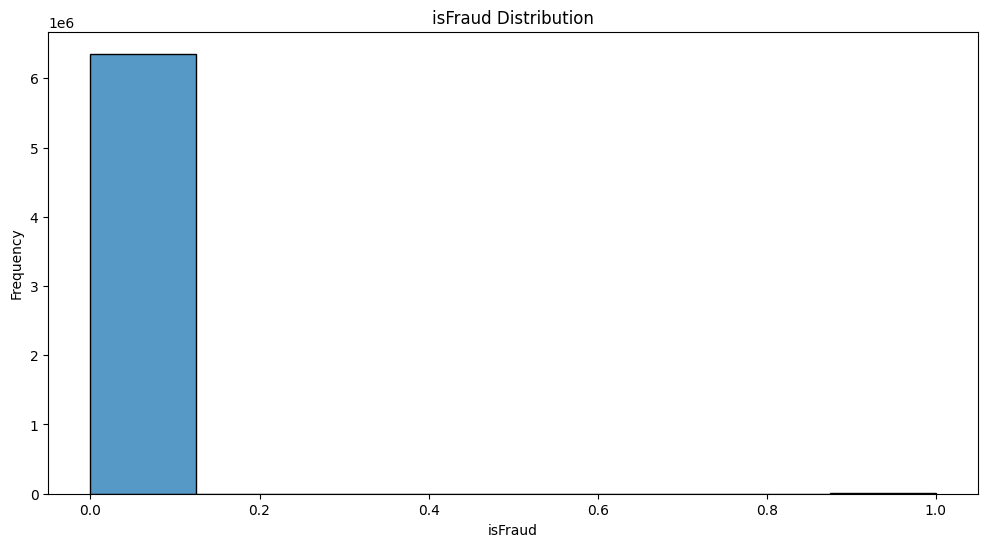

In [23]:
 #Data Distribution Visualization for isFraud
plt.figure(figsize=(12, 6))
sns.histplot(df['isFraud'], bins=8)
plt.title('isFraud Distribution')
plt.xlabel('isFraud')
plt.ylabel('Frequency')
plt.show()

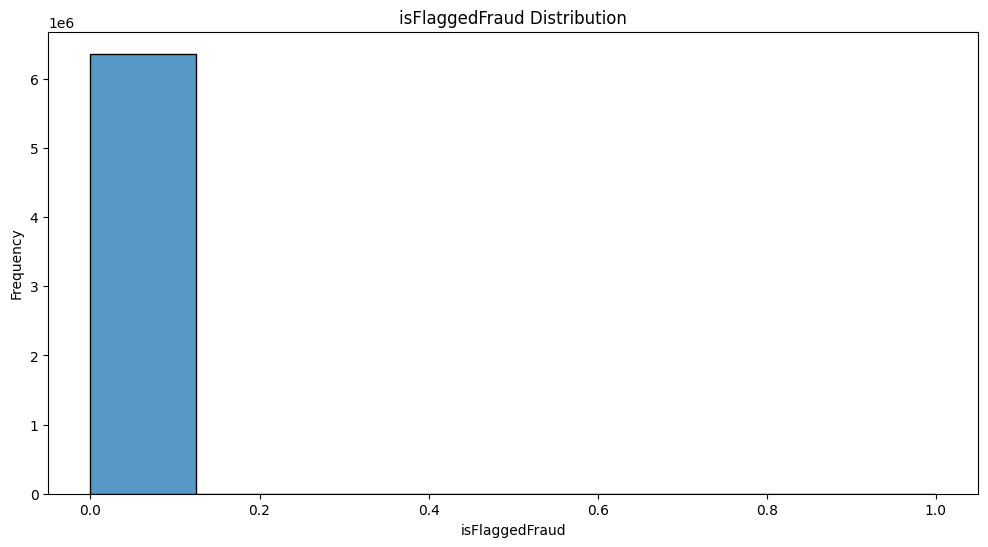

In [24]:
 #Data Distribution Visualization for isFlaggedFraud
plt.figure(figsize=(12, 6))
sns.histplot(df['isFlaggedFraud'], bins=8)
plt.title('isFlaggedFraud Distribution')
plt.xlabel('isFlaggedFraud')
plt.ylabel('Frequency')
plt.show()

In [90]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [91]:
#There are insignificant columns in the dataset. We will only consider the relevant columns and contnue working with those columns. The other columns are dropped
#df1 is newly created dataframe with non relevant features dropped off
df1 = df.drop(['isFlaggedFraud','nameOrig','nameDest' ], axis = 1)
temp = df.drop(['isFlaggedFraud','nameOrig','nameDest'], axis = 1) #backup for further process
df1.head()


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [92]:
temp.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [93]:
fraud_counts= df1['isFraud'].value_counts()
fraud_counts

0    6354407
1       8213
Name: isFraud, dtype: int64

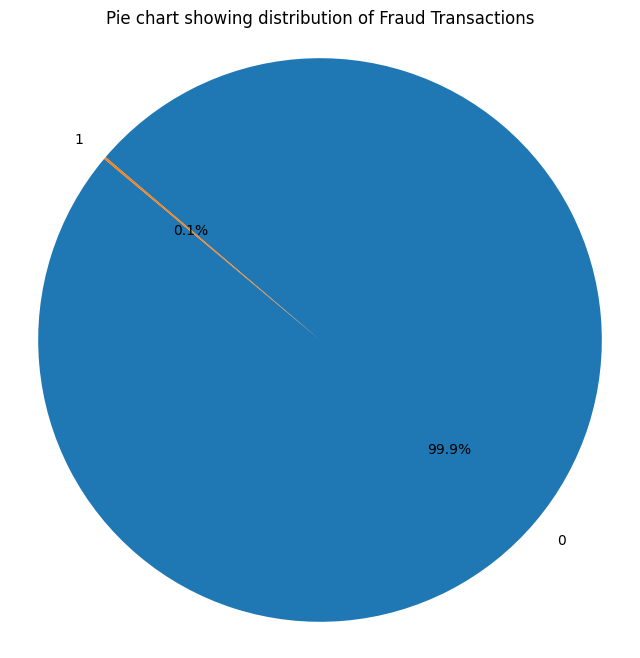

In [94]:
plt.figure(figsize=(8, 8))
plt.pie(fraud_counts, labels=fraud_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Pie chart showing distribution of Fraud Transactions')
plt.axis('equal')
plt.show()

# Note: The conversion of the 'isFraud' column from numeric values (0 and 1) to a class variable serves the purpose of designating its position as the target or dependent variable in a classification scenario, specifically within the realm of fraud detection.

#There are 99.9% Non-fraudulent transactions while 0.1% transactions are fraudulent.

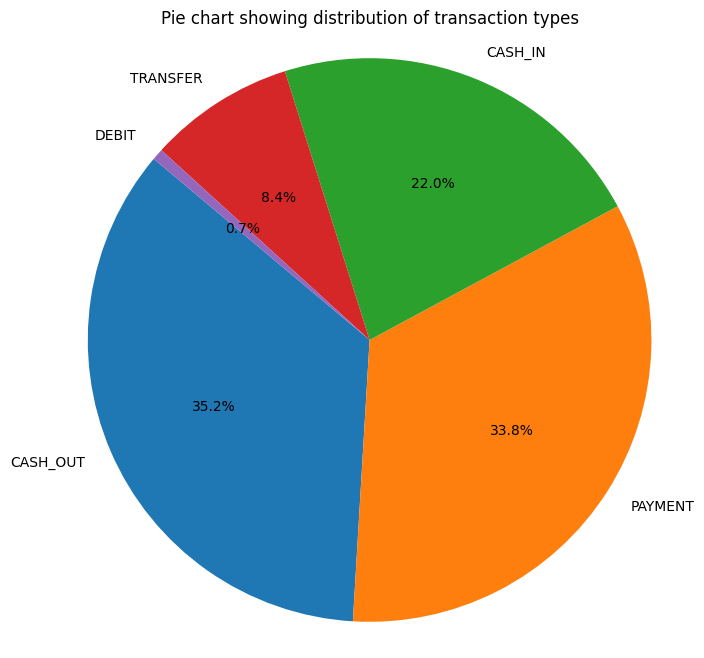

In [95]:
type_counts= df['type'].value_counts()
type_counts
plt.figure(figsize=(8, 8))
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Pie chart showing distribution of transaction types')
plt.axis('equal')
plt.show()

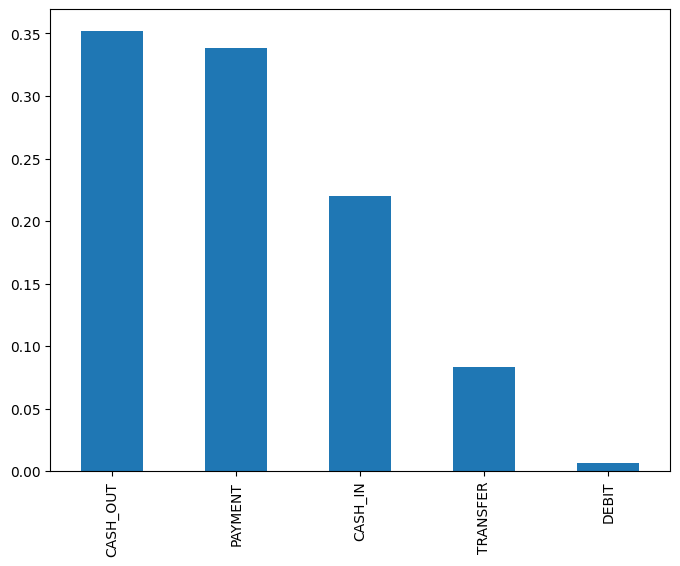

In [96]:
fig = plt.figure(figsize =(8, 6))
df['type'].value_counts(normalize=True).plot(kind='bar')
plt.show()

# **Most of the transactions were made through "CASH_OUT" mode. The "DEBIT"  transactions mode were used the least.**

In [97]:
df1.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [98]:
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [99]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

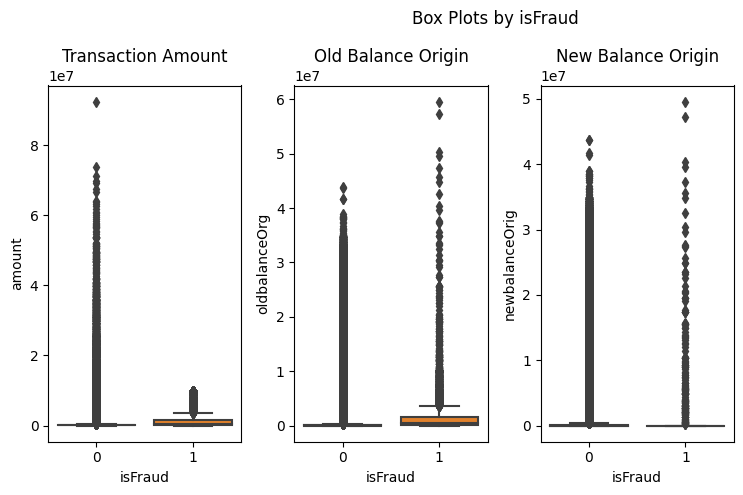

In [100]:
# Generating box plots for the 'amount,' 'oldbalanceOrg,' and 'newbalanceOrig' features, each broken down by whether the transactions are fraudulent or not ('isFraud')

# Setting the figure size
plt.figure(figsize=(10, 5))

# Creating box plots for 'amount', 'oldbalanceOrg', and 'newbalanceOrig' by  (isFraud)
plt.subplot(1, 4, 1)
sns.boxplot(x='isFraud', y='amount', data=df1)
plt.title('Transaction Amount')

plt.subplot(1, 4, 2)
sns.boxplot(x='isFraud', y='oldbalanceOrg', data=df1)
plt.title('Old Balance Origin')

plt.subplot(1, 4, 3)
sns.boxplot(x='isFraud', y='newbalanceOrig', data=df1)
plt.title('New Balance Origin')

# Adding a title to the overall figure
plt.suptitle('Box Plots by isFraud')

# Adjusting the layout
plt.tight_layout()

# Showing the plots
plt.show()

# Note: The box plot shows that there are some unusual data points that might be signs of fraud in transactions. This suggests that the distribution of fraud and non-fraud cases is not balanced. Even though we've spotted these unusual points, we're not getting rid of them right away because there are already very few fraud cases, and removing them might make it harder to study. We'll deal with these unusual points later on, considering the imbalance between fraud and non-fraud cases.

# **BIVARIATE ANALYSIS**

In [101]:
#Spearman's Correlation Matrix
scm =df1.corr(method='spearman')
scm.head()

<ipython-input-101-6733e72c9679>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  scm =df1.corr(method='spearman')


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
step,1.000000,0.000836,-0.006145,-0.010716,-0.004526,-0.005315,0.020819
amount,0.000836,1.000000,0.047642,-0.070543,0.595401,0.670118,0.036060
oldbalanceOrg,-0.006145,0.047642,1.000000,0.803180,0.024034,-0.008188,0.039430
newbalanceOrig,-0.010716,-0.070543,0.803180,1.000000,0.044433,-0.094429,-0.028031
oldbalanceDest,-0.004526,0.595401,0.024034,0.044433,1.000000,0.935802,-0.017141


In [102]:
#Checking the correlation Pearsonmethod
corr_matrix = df1.corr()
corr_matrix

<ipython-input-102-6d9182106b3e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df1.corr()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000


In [103]:
corr_matrix['isFraud'].sort_values(ascending=False)

isFraud           1.000000
amount            0.076688
step              0.031578
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64

In [104]:
scm['isFraud'].sort_values(ascending=False)

isFraud           1.000000
oldbalanceOrg     0.039430
amount            0.036060
step              0.020819
newbalanceDest   -0.005182
oldbalanceDest   -0.017141
newbalanceOrig   -0.028031
Name: isFraud, dtype: float64

# Notes on Pearson Correlation:
'Amount' (0.076688):
There's a positive correlation, albeit a relatively weak one, between the 'Amount' and the likelihood of fraud. While not highly correlated, higher transaction amounts might slightly correlate with a higher chance of fraud.
'OldbalanceOrg' (0.010154) and 'NewbalanceDest' (0.000535):

Both display positive correlations with 'isFraud', but the correlations are quite weak. 'OldbalanceOrg' seems to have a slightly higher positive correlation than 'NewbalanceDest'.
'OldbalanceDest' (-0.005885) and 'NewbalanceOrig' (-0.008148):

Both exhibit negative correlations with 'isFraud', implying that higher values in these features might be associated with a lower likelihood of fraud. However, these correlations are also weak.

conclusion:
The correlations observed between the features and 'isFraud' are generally weak. Among the features, 'Amount' shows the strongest positive correlation, albeit still relatively modest. The negative correlations of 'OldbalanceDest' and 'NewbalanceOrig' suggest a potential but weak inverse relationship between these attributes and the occurrence of fraud.

While these correlations provide some insight, they might not be strong enough to solely rely on for predicting fraud. They can guide feature importance but should be considered alongside other modeling techniques or feature selection strategies for a comprehensive fraud detection model.

#Comparision with Pearson
the Spearman Method
'OldbalanceOrg' (0.039430) and 'Amount' (0.036060):

Both show a positive correlation with 'isFraud'. However, the correlations are relatively weak. This suggests a slight positive relationship between these features and the likelihood of fraud, but the influence might not be significant.
'NewbalanceDest' (-0.005182), 'OldbalanceDest' (-0.017141), 'NewbalanceOrig' (-0.028031):

These features exhibit negative correlations with 'isFraud'. The correlations are weak, indicating that higher values in these features might be associated with a lower likelihood of fraud. Among these, 'NewbalanceOrig' shows the strongest negative correlation.

Conclusion:

Similar to the previous correlations, these coefficients demonstrate weak associations between the features and the 'isFraud' target. While 'OldbalanceOrg' and 'Amount' exhibit weak positive correlations, 'NewbalanceDest', 'OldbalanceDest', and 'NewbalanceOrig' show weak negative correlations. This suggests potential but minor influences of these features on fraud detection.

The relationships captured by these correlations might not be strong enough to solely determine or predict fraudulent activities. It's essential to complement these insights with other modeling techniques or feature selection strategies to build a robust fraud detection model.

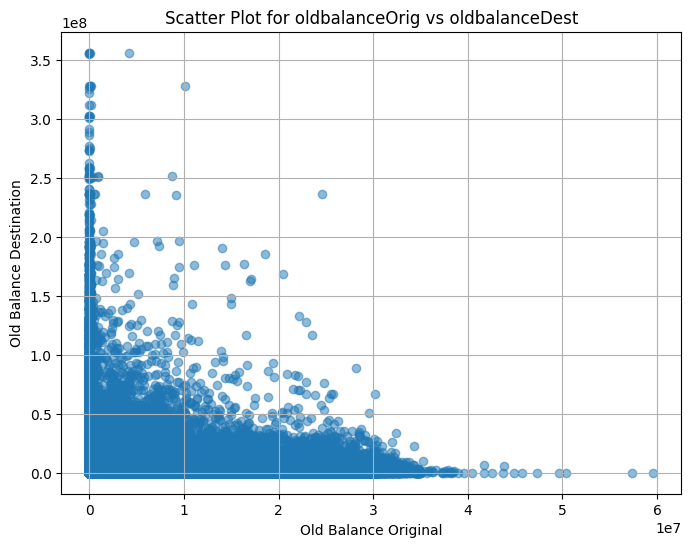

In [105]:
#ScatterPlot for orig old balance vs dest old balance
oldbalanceOrig = df1['oldbalanceOrg']
oldbalanceDest = df1['oldbalanceDest']
plt.figure(figsize=(8, 6))
plt.scatter(oldbalanceOrig, oldbalanceDest, alpha=0.5)
plt.xlabel('Old Balance Original')
plt.ylabel('Old Balance Destination')
plt.title('Scatter Plot for oldbalanceOrig vs oldbalanceDest')
plt.grid(True)
plt.show()

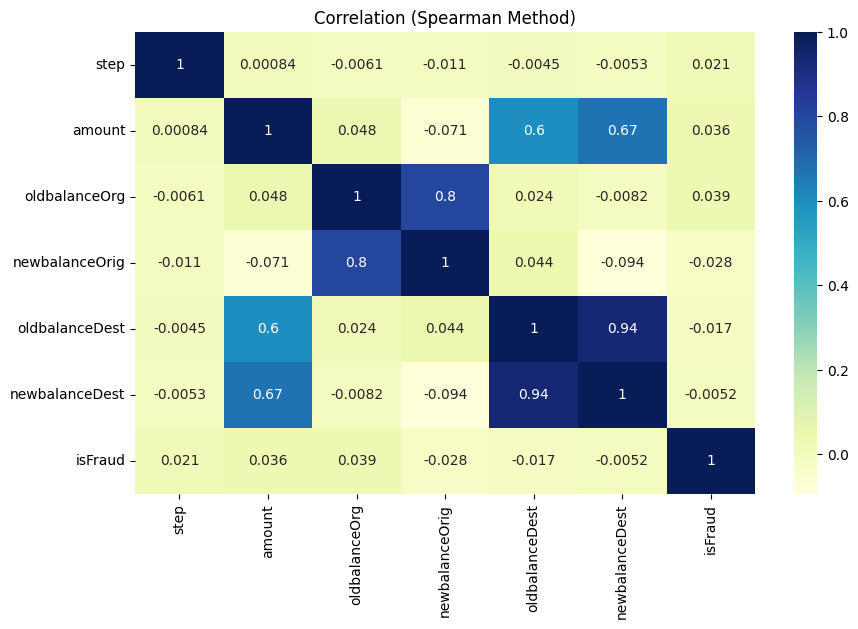

In [106]:
plt.figure(figsize=(10, 6))
sns.heatmap(scm, annot=True, cmap='YlGnBu')
plt.title('Correlation (Spearman Method)')
plt.show()

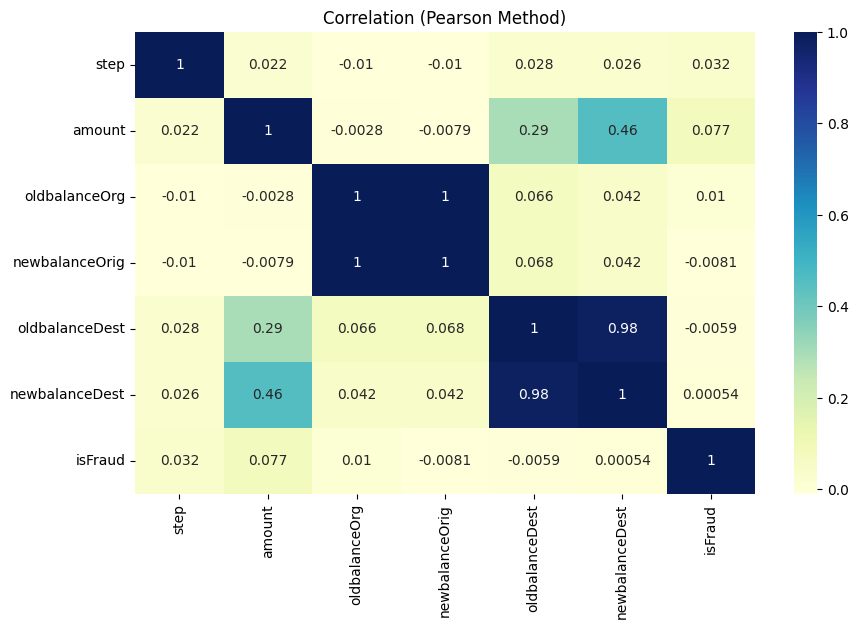

In [107]:
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu')
plt.title('Correlation (Pearson Method)')
plt.show()

#Findings : The correlation matrix using Pearson and Spearman method suggest that there is stringly positive correlation between Newbalance Orig and Old balanceorg

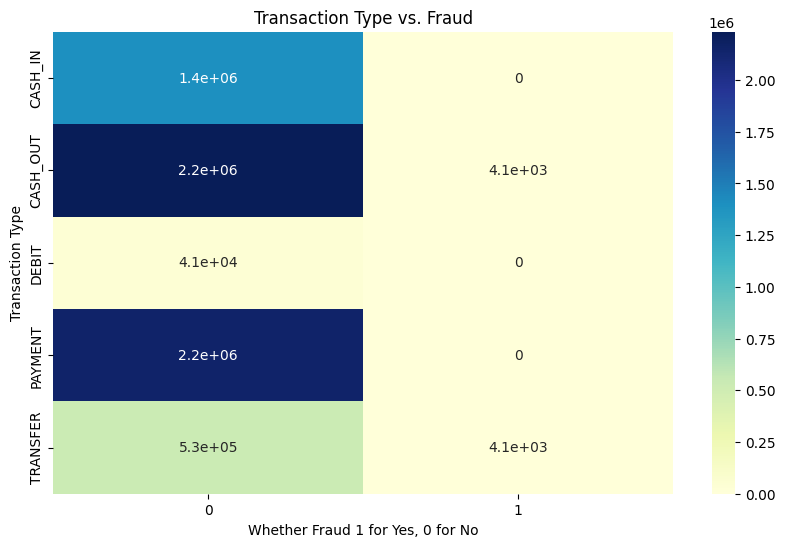

In [108]:
# crosstab representation
ctab = pd.crosstab(df['type'], df['isFraud'])
plt.figure(figsize=(10, 6))
sns.heatmap(ctab, annot=True, cmap='YlGnBu')
plt.title('Transaction Type vs. Fraud')
plt.xlabel('Whether Fraud 1 for Yes, 0 for No')
plt.ylabel('Transaction Type')
plt.show()

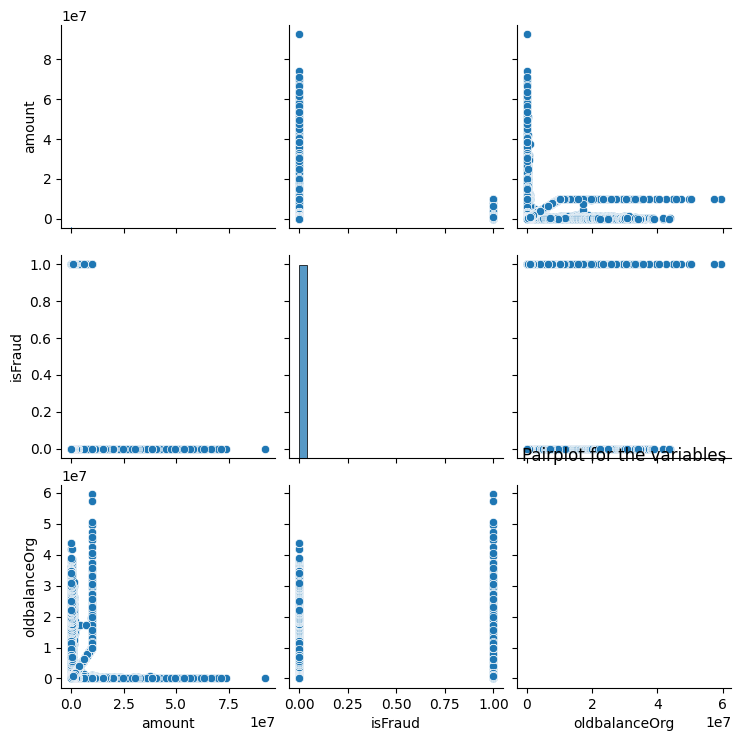

In [109]:
# Multivariate Analysis
# Pairplot (for variables)
sns.pairplot(temp[['amount', 'isFraud','oldbalanceOrg']])
plt.title('Pairplot for the variables')
plt.show()


# Note: It is important to note that the data is skewed to the left or negatively skewed


In [110]:
#Applying one hot encoding for the type column
temp = pd.get_dummies(df1, columns=['type'],prefix='type')
temp.head()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,1,0


In [111]:
#Normalizing using Robust Scaler
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
scaled = rs.fit_transform(temp)
dfs = pd.DataFrame(scaled, columns = temp.columns)
dfs.head()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-1.329609,-0.332932,1.452991,1.111175,-0.140722,-0.193057,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.329609,-0.373762,0.065610,0.134375,-0.140722,-0.193057,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.329609,-0.382380,-0.130708,0.000000,-0.140722,-0.193057,1.0,0.0,0.0,0.0,0.0,1.0
3,-1.329609,-0.382380,-0.130708,0.000000,-0.118260,-0.193057,1.0,0.0,1.0,0.0,0.0,0.0
4,-1.329609,-0.323571,0.254820,0.207169,-0.140722,-0.193057,0.0,0.0,0.0,0.0,1.0,0.0


In [112]:
dfs[['isFraud', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']] = dfs[['isFraud', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']].astype(int)


In [113]:
dfs.head()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-1.329609,-0.332932,1.452991,1.111175,-0.140722,-0.193057,0,0,0,0,1,0
1,-1.329609,-0.373762,0.065610,0.134375,-0.140722,-0.193057,0,0,0,0,1,0
2,-1.329609,-0.382380,-0.130708,0.000000,-0.140722,-0.193057,1,0,0,0,0,1
3,-1.329609,-0.382380,-0.130708,0.000000,-0.118260,-0.193057,1,0,1,0,0,0
4,-1.329609,-0.323571,0.254820,0.207169,-0.140722,-0.193057,0,0,0,0,1,0


In [114]:
def count(df, txn_column, fraud_column, value):
    fraud_mask = df[fraud_column] == value
    fraud_data = df[fraud_mask]
    fraud_counts = fraud_data[txn_column].value_counts().reset_index()
    fraud_counts.columns = [txn_column, 'Fraud Count']
    return fraud_counts

fraud_txn_count = count(df, 'type', 'isFraud', 1)
print(fraud_txn_count)


       type  Fraud Count
0  CASH_OUT         4116
1  TRANSFER         4097


# The above analysis represents that the fraud transaction were only occuring in CASH_OUT and TRANSFER transactions.
#The other three payment methods are non-fraudulent.

# **ANOVA TEST**

In [115]:
from scipy.stats import f_oneway

def anova(df, target_column):
    numerical_columns = df.select_dtypes(include='number').columns
    results = pd.DataFrame(columns=['Column', 'F-statistic', 'P-value'])

    for column in numerical_columns:
        if df[column].nunique() > 1:
            groups = [df[column][df[target_column] == group] for group in df[target_column].unique()]
            f_statistic, p_value = f_oneway(*groups)
            results = pd.concat([results, pd.DataFrame({'Column': [column], 'F-statistic': [f_statistic], 'P-value': [p_value]})], ignore_index=True)

    return results

results = anova(temp, 'isFraud')
print(results)



/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4167: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


            Column   F-statistic        P-value
0             step  6.350772e+03   0.000000e+00
1           amount  3.764066e+04   0.000000e+00
2    oldbalanceOrg  6.561317e+02  1.054289e-144
3   newbalanceOrig  4.224584e+02   7.168312e-94
4   oldbalanceDest  2.203865e+02   7.463207e-50
5   newbalanceDest  1.823504e+00   1.768967e-01
6          isFraud           inf   0.000000e+00
7     type_CASH_IN  2.319280e+03   0.000000e+00
8    type_CASH_OUT  8.061837e+02  2.504585e-177
9       type_DEBIT  5.390183e+01   2.107862e-13
10    type_PAYMENT  4.204281e+03   0.000000e+00
11   type_TRANSFER  1.851719e+04   0.000000e+00


# Findings on ANOVA test :
Insights from F-Statistic and P-Value:
'Amount':

The F-statistic for 'Amount' is exceptionally high (3.764066e+04), indicating significant variability in this feature concerning the 'isFraud' target. The p-value (effectively zero) confirms that this variability is highly unlikely to be due to random chance, indicating 'Amount' is a crucial and strong indicator of fraudulent transactions.
'OldbalanceOrg' and 'NewbalanceOrig':

Both exhibit considerably high F-statistics (6.561317e+02 and 4.224584e+02, respectively) with extremely low p-values (1.054289e-144 and 7.168312e-94). This indicates significant variability in these attributes concerning fraud, making them influential factors in identifying fraudulent transactions.
'OldbalanceDest' and 'NewbalanceDest':

Both features have lower but still significant F-statistics (2.203865e+02 and 1.823504e+00) with associated p-values of 7.463207e-50 and 1.768967e-01. While 'OldbalanceDest' shows substantial variability related to fraud, 'NewbalanceDest' has a less pronounced impact.
'isFraud':

The F-statistic for 'isFraud' is infinite, which suggests this variable might not be suitable for ANOVA due to constant input arrays, making the F-statistic undefined. The associated p-value is effectively zero, supporting its significance in differentiating fraudulent transactions.

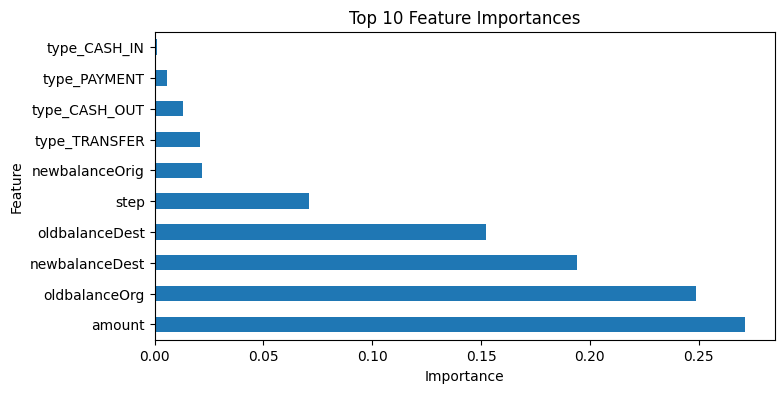

In [116]:
# Using Random Forest Classifier to determine feature importances.

X = dfs.drop('isFraud', axis=1).head(300000)
y = dfs['isFraud'].head(300000)

# Creating and fitting a Random Forest model
model = RandomForestClassifier()
model.fit(X, y)

# Getting feature importances
feature_importances = model.feature_importances_
features = X.columns

# Creating a Series with feature importances
feature_importance_series = pd.Series(feature_importances, index=features)

# Sorting feature importances in descending order
feature_importance_series = feature_importance_series.sort_values(ascending=False)

# Plotting the top 'n' most important features
n = 10  # Setting the number of features to display
plt.figure(figsize=(8, 4))
feature_importance_series.head(n).plot(kind='barh')
plt.title(f'Top {n} Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

As from the correlation matrix ,it shows that "NewbalanceOrig" and"OldbalanceOrg" variables are highly correlated,So we can remove one of the feature ,further from the Top 10 feature imporatance ,it as been found that "newbalanceOrig" is less important as compared to "OldbalanceOrg".From this, deleting "newbalanceOrig" is a good idea ,however "type_DEBIT" and"type_Payment" are also less imporatnt features as comparative t others, but keeping them for the loss of information would be a good option


In [117]:
dfs.columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'type_CASH_IN', 'type_CASH_OUT',
       'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')

In [118]:
dfs = dfs.drop('newbalanceOrig', axis=1)
dfs.columns

Index(['step', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'newbalanceDest',
       'isFraud', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')

# **Splitting the data into X and target variable to y**

In [119]:
dfs.columns

Index(['step', 'amount', 'oldbalanceOrg', 'oldbalanceDest', 'newbalanceDest',
       'isFraud', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')

In [120]:
X = dfs.drop('isFraud', axis=1)  # Features
y = dfs['isFraud']  # Target variable

In [121]:
X.head()

,step,amount,oldbalanceOrg,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-1.329609,-0.332932,1.452991,-0.140722,-0.193057,0,0,0,1,0
1,-1.329609,-0.373762,0.065610,-0.140722,-0.193057,0,0,0,1,0
2,-1.329609,-0.382380,-0.130708,-0.140722,-0.193057,0,0,0,0,1
3,-1.329609,-0.382380,-0.130708,-0.118260,-0.193057,0,1,0,0,0
4,-1.329609,-0.323571,0.254820,-0.140722,-0.193057,0,0,0,1,0


In [122]:
y.head()

0    0
1    0
2    1
3    1
4    0
Name: isFraud, dtype: int64

# Using TRAIN_TEST_SPLIT with 80:20 proportion

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20, random_state=42)

In [124]:
dfs['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [125]:
y_train.value_counts(normalize=True)

0    0.998705
1    0.001295
Name: isFraud, dtype: float64

In [126]:
y_test.value_counts(normalize=True)

0    0.998727
1    0.001273
Name: isFraud, dtype: float64

In [127]:
#Normalizing using Robust Scaler
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
scaled = rs.fit_transform(dfs)
dfs = pd.DataFrame(scaled, columns = dfs.columns)
dfs.head()

,step,amount,oldbalanceOrg,oldbalanceDest,newbalanceDest,isFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,-1.329609,-0.332932,1.452991,-0.140722,-0.193057,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.329609,-0.373762,0.065610,-0.140722,-0.193057,0.0,0.0,0.0,0.0,1.0,0.0
2,-1.329609,-0.382380,-0.130708,-0.140722,-0.193057,1.0,0.0,0.0,0.0,0.0,1.0
3,-1.329609,-0.382380,-0.130708,-0.118260,-0.193057,1.0,0.0,1.0,0.0,0.0,0.0
4,-1.329609,-0.323571,0.254820,-0.140722,-0.193057,0.0,0.0,0.0,0.0,1.0,0.0


In [128]:
dfs[['isFraud', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']] = dfs[['isFraud', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER']].astype(int)

A SHORT NOTE ON OVERSAMPLING:
1. Focuses on the "Highs" of the Feature in Question:
Oversampling primarily targets the minority class, which is often referred to as the "low" or "rare" class. It aims to increase the number of instances in the minority class to balance it with the majority class, which is typically the "high" or "common" class. This rebalancing helps machine learning models perform better by preventing them from being biased toward the majority class.

2. Preservation of Majority Class Data:
Oversampling does not remove or alter any instances of the majority class (the "high" or overrepresented class). The data points belonging to the majority class are typically kept as they are to preserve the valuable information they contain. Oversampling focuses on increasing the number of instances in the minority class, often by adding new instances or replicating existing ones.

3. Efficient Utilization of Available Data:
One of the advantages of oversampling is that it allows for the maximum utilization of the available data. By increasing the number of minority class instances, it helps create a more balanced distribution of class labels without discarding any data from the majority class.

In [129]:
#SMOTE Oversampling
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto')
X_train_os,y_train_os = smote.fit_resample(X_train,y_train)
print(X_train_os.shape)
print(y_train_os.shape)

(10167006, 10)
(10167006,)


A SHORT NOTE ON UNDERSAMPLING:
1. Focuses on the "Lows" of the Feature in Question:
Undersampling primarily targets the majority class, which is often referred to as the "high" or "common" class. It aims to reduce the number of instances in the majority class to balance it with the minority class, which is typically the "low" or "rare" class. This rebalancing helps machine learning models perform better by preventing them from being biased toward the majority class.

2. Preservation of Minority Class Data:
Undersampling does not remove or alter any instances of the minority class (the "low" or underrepresented class). The data points belonging to the minority class are typically kept as they are to preserve the valuable information they contain. Undersampling focuses on reducing the abundance of the majority class, often by randomly removing some of its data points.

In [130]:
pip install imblearn

# We will be using the OVERSAMPLED data for our further model design as it seems to be an efficient data handling measure.

# **Using LOGISTIC REGRESSION MODEL with Time-series Split KFold cross validation**

In [131]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Assuming X_train_os and y_train_os are your training data and labels

# Time series cross-validation
time_series_cv = TimeSeriesSplit(n_splits=5)

# Standardize the features
scaler = StandardScaler()
X_train_os_scaled = scaler.fit_transform(X_train_os)

# Logistic Regression model
lr_model = LogisticRegression(max_iter=1000000)

# Flatten the y_train_os
y_train_os_array = y_train_os.values.ravel()

# Cross-validation scores
lr_scores = cross_val_score(lr_model, X_train_os_scaled, y_train_os_array, cv=time_series_cv, scoring='accuracy')

# Display the results
print("Logistic Regression Time Series Cross-validation scores:")
print(lr_scores)
print(f"Average Accuracy: {lr_scores.mean()}\n")


Logistic Regression Time Series Cross-validation scores:
[0.99898318 0.99902449 0.28169119 0.82012699 0.90666161]
Average Accuracy: 0.8012974911198046



In [132]:
# Decision Tree model
dt_model = DecisionTreeClassifier()
y_train_os_array = y_train_os.values.ravel()
dt_scores = cross_val_score(dt_model, X_train_os, y_train_os_array, cv=time_series_cv, scoring='accuracy')
print("Decision Tree Time Series Cross-validation scores:")
print(dt_scores)
print(f"Average Accuracy: {dt_scores.mean()}\n")

Decision Tree Time Series Cross-validation scores:
[0.99944231 0.99950074 0.85072302 0.99852759 0.99930068]
Average Accuracy: 0.9694988672181367



In [133]:
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=50)
y_train_os_array = y_train_os.values.ravel()
rf_scores = cross_val_score(rf_model, X_train_os, y_train_os_array, cv=time_series_cv, scoring='accuracy')
print("Random Forest Time Series Cross-validation scores:")
print(rf_scores)
print(f"Average Accuracy: {rf_scores.mean()}\n")



Random Forest Time Series Cross-validation scores:
[0.9996406  0.99965772 0.78515445 0.99975096 0.99991915]
Average Accuracy: 0.9568245754944966



In [134]:


# Scale the features to ensure non-negative values
scaler = MinMaxScaler()
X_train_os_mscaled = scaler.fit_transform(X_train_os)

# Naive Bayes model (MultinomialNB)
nb_model = MultinomialNB()

# Flatten the y_train_os if needed
y_train_os_array = y_train_os.values.ravel()

# Cross-validation scores
nb_scores = cross_val_score(nb_model, X_train_os_mscaled, y_train_os_array, cv=time_series_cv, scoring='accuracy')

# Display the results
print("Naive Bayes (MultinomialNB) Time Series Cross-validation scores:")
print(nb_scores)
print(f"Average Accuracy: {nb_scores.mean()}\n")


Naive Bayes (MultinomialNB) Time Series Cross-validation scores:
[0.99868516 0.99872765 0.00388728 0.4985692  0.72948378]
Average Accuracy: 0.6458706132365812



In [135]:
# Initializing the Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=50)

# Training the model using the training data
random_forest_model.fit(X_train_os, y_train_os_array)

RandomForestClassifier(n_estimators=50)

In [136]:
# Initializing the Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Fitting the model to the training data
decision_tree_model.fit(X_train_os, y_train_os_array)

DecisionTreeClassifier(random_state=42)

In [137]:
# Creating the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000000)

# Fitting the model on the training data
logistic_model.fit(X_train_os_scaled, y_train_os_array)

LogisticRegression(max_iter=1000000)

In [138]:
# Creating the Naive Bayes model
Naive_Bayes_model = MultinomialNB()

# Fitting the model on the training data
Naive_Bayes_model.fit(X_train_os_mscaled, y_train_os_array)

MultinomialNB()

In [139]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Predicting the target values using the Random Forest model

X_test['step'] = pd.to_numeric(X_test['step'])


# Evaluating on test data
y_pred = random_forest_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

Accuracy: 0.9991277178269329
Precision: 0.6075949367088608
Recall: 0.8888888888888888
F1 Score: 0.7218045112781953


In [141]:
# Random Forest Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1269974     930]
 [    180    1440]]


In [142]:
# Predicting the target values using the Decision Tree model

# Evaluating on test data
y_pred = decision_tree_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

Accuracy: 0.9987214386526305
Precision: 0.4987843001042028
Recall: 0.8864197530864197
F1 Score: 0.6383640809068682


Confusion Matrix:
[[1269461    1443]
 [    184    1436]]


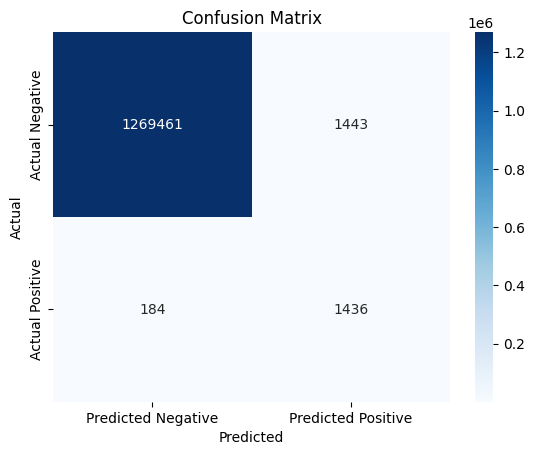

In [143]:
# Decision Tree Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])

# Add labels and title
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

In [144]:
# Predicting the target values using the Logistic Regression model

# Evaluating on test data
y_pred = logistic_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Accuracy: 0.8302680342374682
Precision: 0.004951226721844517
Recall: 0.6617283950617284
F1 Score: 0.009828910934663414


In [145]:
# Logistic Regression Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1055464  215440]
 [    548    1072]]


In [146]:
# Predicting the target values using the Naive_Bayes_model

# Evaluating on test data
y_pred = Naive_Bayes_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(


Accuracy: 0.6299103199625311
Precision: 0.0031904848605459604
Recall: 0.9302469135802469
F1 Score: 0.006359159595073023


In [148]:
# Naive_Bayes_model Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[800069 470835]
 [   113   1507]]


In [149]:
# Calculating AUC and plotting ROC curve

# Random Forest model
rf_probs = random_forest_model.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

# Decision Tree model
dt_probs = decision_tree_model.predict_proba(X_test)[:, 1]
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
dt_auc = roc_auc_score(y_test, dt_probs)

# Logistic Regression model
lr_probs = logistic_model.predict_proba(X_test)[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# Naive_Bayes model
nb_probs = Naive_Bayes_model.predict_proba(X_test)[:, 1]
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs)
nb_auc = roc_auc_score(y_test, nb_probs)
# Print AUC for each model
print(f"Random Forest AUC: {rf_auc}")
print(f"Decision Tree AUC: {dt_auc}")
print(f"Logistic Regression AUC: {lr_auc}")
print(f"Naive Bayes AUC: {nb_auc}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(


Random Forest AUC: 0.9975523153422902
Decision Tree AUC: 0.9426421704064757
Logistic Regression AUC: 0.8668688492309121
Naive Bayes AUC: 0.8646493607486004


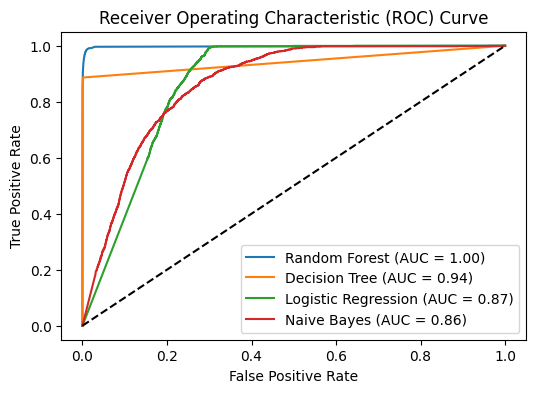

In [150]:
# Plotting ROC curves for all three models
plt.figure(figsize=(6, 4))

# Random Forest
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.2f})')

# Decision Tree
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_auc:.2f})')

# Logistic Regression
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.2f})')
# Naive_Bayes
plt.plot(nb_fpr, nb_tpr, label=f'Naive Bayes (AUC = {nb_auc:.2f})')

# Plotting the ROC curve for a random classifier
plt.plot([0, 1], [0, 1], linestyle='--', color='black')

# Customizing the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()